In [5]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, Descent, params, throttle, Dropout, @epochs, testmode!

using Base.Iterators: repeated

using Plots, DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter
# using the pyplot backend
pyplot()

using BSON: @save, @load
using NNlib
using LaTeXStrings

# DATA IMPORT

In [6]:
X_columns = h5read("./data/DataSet.hdf5", "X_columns")

X_entropy = h5read("./data/DataSet.hdf5", "X_entropy")
X_entropy_sc = h5read("./data/DataSet.hdf5", "X_entropy_sc")

X_tv = h5read("./data/DataSet.hdf5", "X_tv")
X_tv_sc = h5read("./data/DataSet.hdf5", "X_tv_sc")
y_tv = h5read("./data/DataSet.hdf5", "y_tv")

X_train = h5read("./data/DataSet.hdf5", "X_train")
X_train_sc = h5read("./data/DataSet.hdf5", "X_train_sc")
y_train = h5read("./data/DataSet.hdf5", "y_train")

X_valid = h5read("./data/DataSet.hdf5", "X_valid")
X_valid_sc = h5read("./data/DataSet.hdf5", "X_valid_sc")
y_valid = h5read("./data/DataSet.hdf5", "y_valid")

X_test = h5read("./data/DataSet.hdf5", "X_test")
X_test_sc = h5read("./data/DataSet.hdf5", "X_test_sc")
y_test = h5read("./data/DataSet.hdf5", "y_test")

X_scaler_mean = h5read("./data/DataSet.hdf5", "X_scaler_mean")
X_scaler_var = h5read("./data/DataSet.hdf5", "X_scaler_var")
println("loaded")
println("\nFeatures in X_ arrays are")
println(X_columns)
println("\nShape of X train and valid is")
println(size(X_tv))

loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "nbot", "ifsm", "ifst", "ap", "b", "T", "Sc", "tg", "ScT"]

Shape of X train and valid is
(13, 1145)


In [7]:
function prepare_datas(X_,y_)
    
    y = reshape(y_[:],1,length(y_))

    ap = reshape(X_[8,:],1,size(X_,2))
    b = reshape(X_[9,:],1,size(X_,2))
    T = reshape(X_[10,:],1,size(X_,2))
    #be = reshape(X_[11,:],1,size(X_,2))
    sc = reshape(X_[11,:],1,size(X_,2))
    tg = reshape(X_[12,:],1,size(X_,2))
    sct = reshape(X_[13,:],1,size(X_,2))
    x = [X_[1:7,:];T]
    return x, y, T, ap, b, sc, tg, sct
end


prepare_datas (generic function with 1 method)

# Model

## Load network

In [8]:
@load "./model/m1.bson" m1
@load "./model/Ae.bson" Ae

## Load functions

In [9]:
include("flux_functions.jl")

loss_global (generic function with 1 method)

# Look at last results

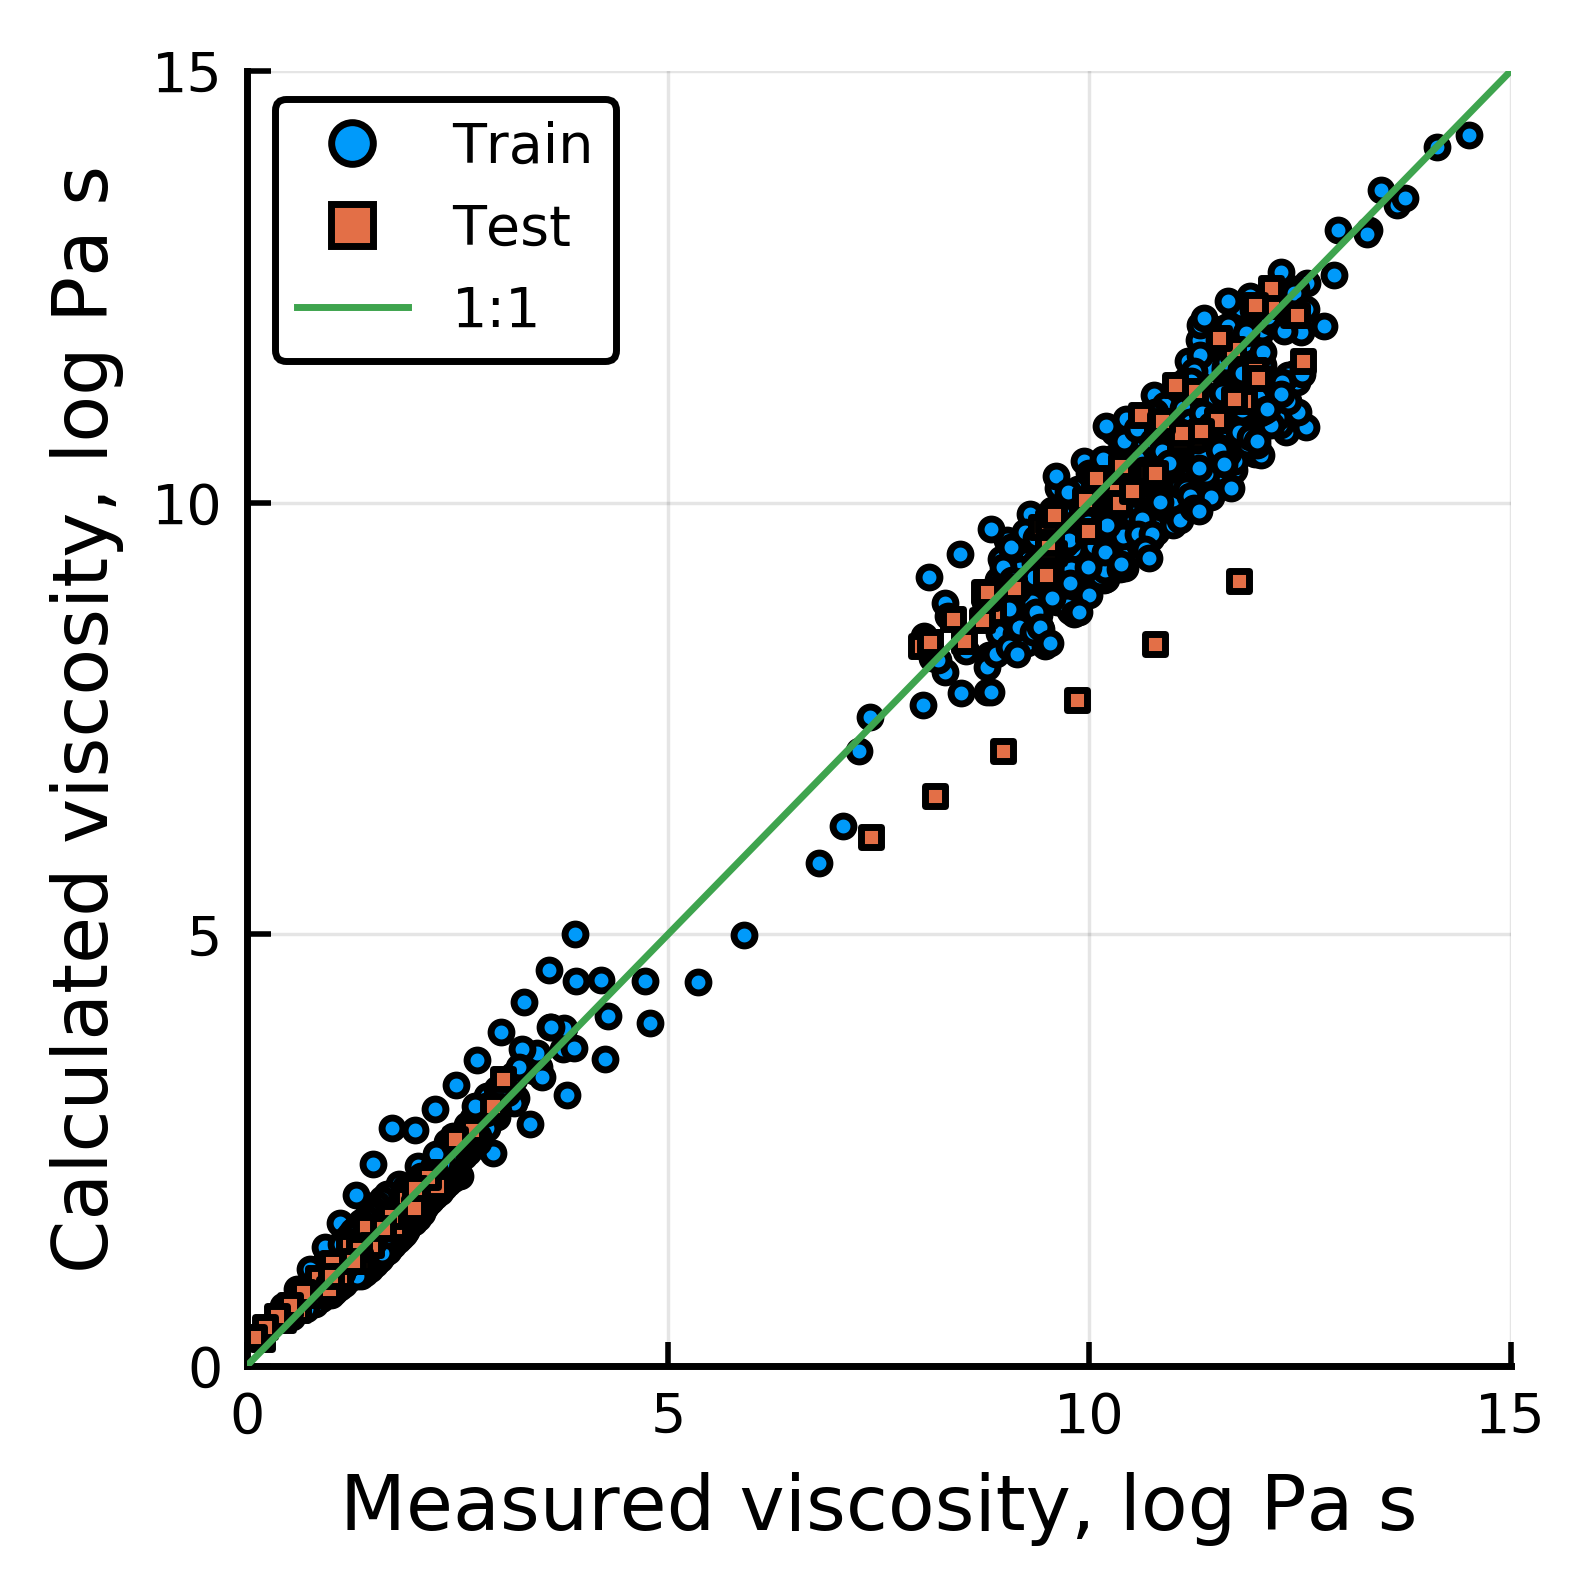

In [13]:
x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)

p1 = scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],
    label="Train",legend=:topleft,m=(3, :auto),
xlabel="Measured viscosity, log Pa s",
ylabel="Calculated viscosity, log Pa s",
xlim=(0,15),
ylim=(0,15),
dpi=500,
size=(300,300))

scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],label="Test",m=(3, :auto))
plot!([0.,16.],[0.,16.],label="1:1")

savefig("./figures/KNAS_visco.png")

In [14]:
print(loss_n(x_train_,T_train_,ap_train_, b_train_,y_train_))
print("\n")
print(loss_n(x_valid_,T_valid_,ap_valid_, b_valid_,y_valid_))

0.5353623574204611 (tracked)
0.5645523332955397 (tracked)

# TEST

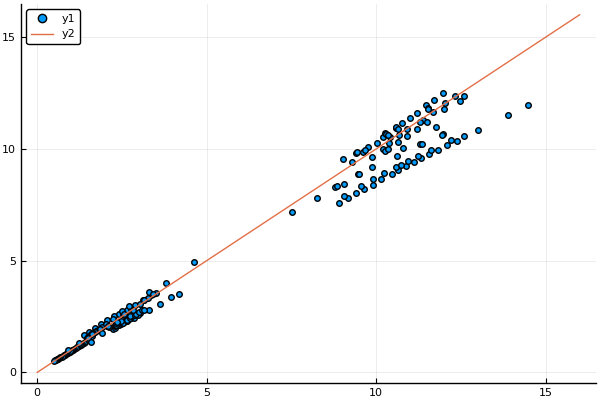

In [15]:
x_test, y_test, T_test, ap_test, b_test, sc_test, tg_test = prepare_datas(X_test_sc,y_test)

scatter(vec(y_test),model(x_test,T_test,ap_test,b_test).data[:])
plot!([0.,16.],[0.,16.])

#println(mse(y_test,model(x_test,T_test,ap_test,b_test).data[:]))

In [16]:
X_visu_NKS

UndefVarError: UndefVarError: X_visu_NKS not defined

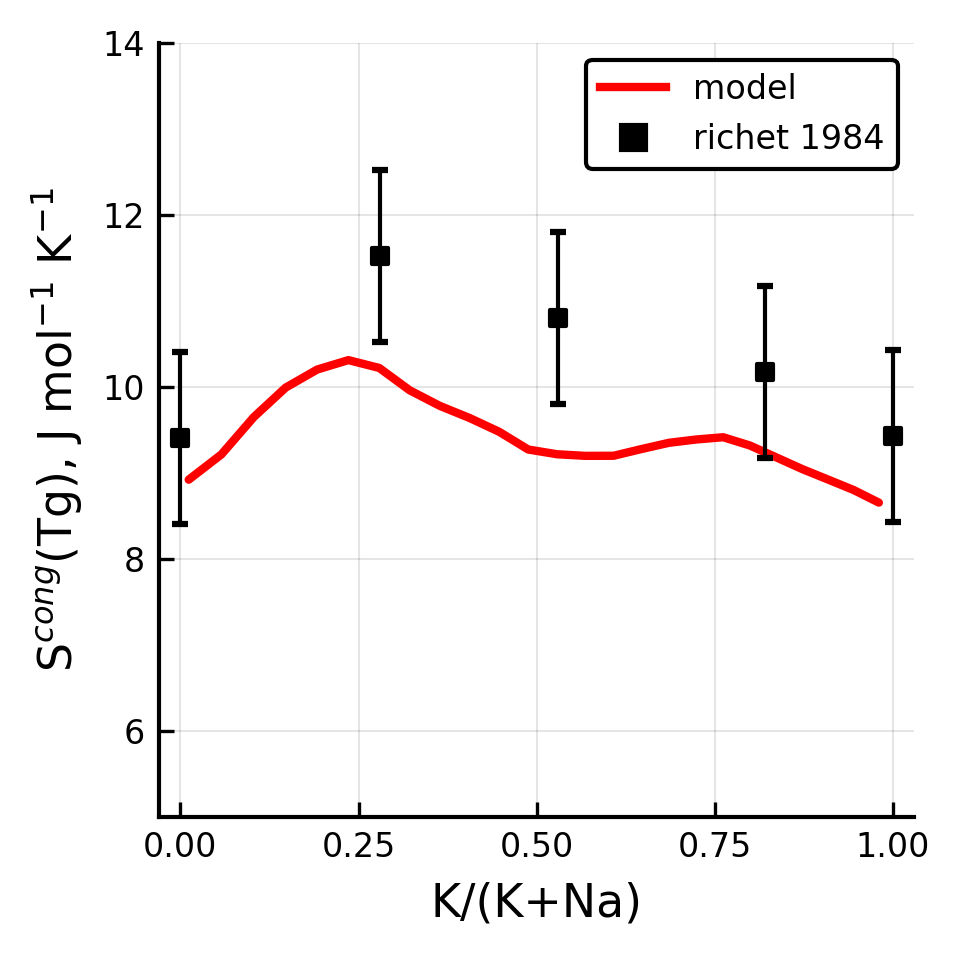

In [17]:
X_visu_NKS = h5read("./data/DataSet_visu.hdf5", "X_arti_NKS")

x_visu_xaxis = X_visu_NKS[1:7,:].*sqrt.(X_scaler_var[1:7]) .+ X_scaler_mean[1:7]

#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

plot(x_visu_xaxis[4,:]./(x_visu_xaxis[3,:].+x_visu_xaxis[4,:]),
    ScTg(X_visu_NKS).data'[:],
    line=(1,2,:red),label="model",ylim=(5,14),
dpi=300,size=(300,300),
xlabel="K/(K+Na)",
ylabel=L"S$^{cong}$(Tg), J mol$^{-1}$ K$^{-1}$")

scatter!([0,0.28,0.53,0.82,1.0],
    [32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,
    err = 1.0,
    label="richet 1984",
    marker=(:square,"black",4),
    c = :black)

savefig("./figures/KNS_75_Sc.png")

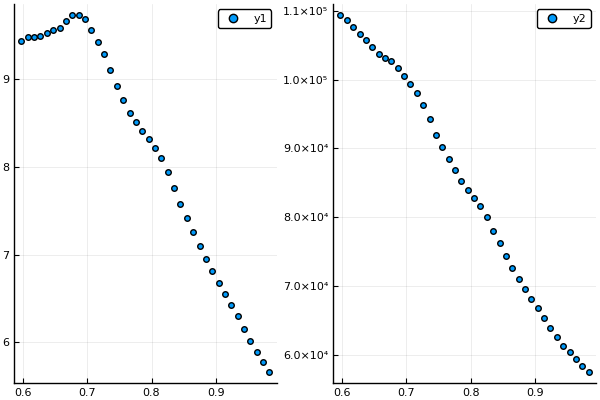

In [69]:
X_visu_NS = h5read("./data/DataSet_visu.hdf5", "X_arti_NS")
xns_visu_xaxis = copy(X_visu_NS)

for i = 1:7
    xns_visu_xaxis[i,:] = X_visu_NS[i,:].*sqrt.(X_scaler_var[i]) .+ X_scaler_mean[i]
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter([xns_visu_xaxis[1,:],xns_visu_xaxis[1,:]],
    [ScTg(X_visu_NS).data'[:],Be(X_visu_NS).data'[:]],
layout=2)
#scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

In [299]:
predictions_train = predict(x)

Tracked 620×620 Array{Float64,2}:
 -4.49918  -4.49918  -4.49918  -4.49918  …  -4.4996   -4.4996   -4.4996 
 -4.49916  -4.49916  -4.49916  -4.49916     -4.49959  -4.49959  -4.49959
 -4.49912  -4.49912  -4.49912  -4.49912     -4.49957  -4.49957  -4.49957
 -4.49909  -4.49909  -4.49909  -4.49909     -4.49955  -4.49955  -4.49955
 -4.49904  -4.49904  -4.49904  -4.49904     -4.49953  -4.49953  -4.49953
 -4.49901  -4.49901  -4.49901  -4.49901  …  -4.49951  -4.49951  -4.49951
 -4.49896  -4.49896  -4.49896  -4.49896     -4.49949  -4.49949  -4.49949
 -4.49892  -4.49892  -4.49892  -4.49892     -4.49947  -4.49947  -4.49947
 -4.49885  -4.49885  -4.49885  -4.49885     -4.49943  -4.49943  -4.49943
 -4.49882  -4.49882  -4.49882  -4.49882     -4.49942  -4.49942  -4.49942
 -4.49871  -4.49871  -4.49871  -4.49871  …  -4.49936  -4.49936  -4.49936
 -4.49866  -4.49866  -4.49866  -4.49866     -4.49934  -4.49934  -4.49934
 -4.49861  -4.49861  -4.49861  -4.49861     -4.49931  -4.49931  -4.49931
  ⋮              

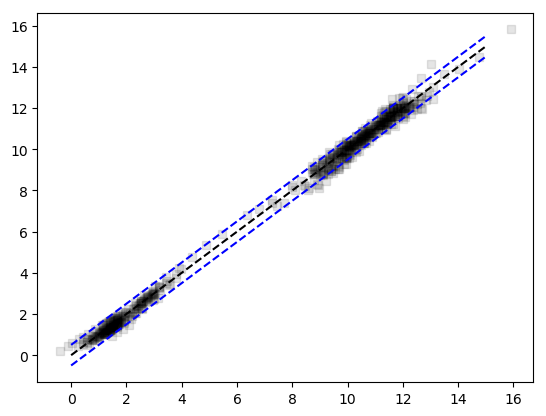

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f041fbb1cc0>

In [197]:
plot(predictions_train.data[:],y.parent[:],"ks",alpha=0.1)
plot([0,15],[0,15],"k--")
plot([0,15.0],[0,15.].-0.5,"b--")
plot([0,15.],[0,15.].+0.5,"b--")

In [195]:
plot([0,12]-0.5,[0,12]-0.5,"k--")

MethodError: MethodError: no method matching -(::Array{Int64,1}, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:397
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:298
  -(!Matched::Missing, ::Number) at missing.jl:97
  ...

In [188]:
predictions_train.data[:]

620-element Array{Float64,1}:
  2.3032444067117757
  2.623692405633248 
  3.027915455938361 
  3.4222450165673743
  3.8926449255113944
  4.370103390672524 
  4.8876503648035   
  5.469334558026265 
  6.356743420865268 
  6.78613859050153  
  8.327278676684431 
  9.051372238986819 
  9.944407111041677 
  ⋮                 
  1.4055438658956634
  1.4422492073169009
  1.479413679478652 
  1.5170459511904548
  1.5551549108774632
  1.5937496735794525
  1.6328395882192055
  1.6724342451524592
  9.332781439644776 
 10.09932163190039  
 10.621319672155154 
 11.212695098263817 

In [191]:
m1(x)

Tracked 1×620 Array{Float32,2}:
 15123.9  15123.9  15123.9  15123.9  …  8035.39  8035.39  8035.39  8035.39